In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

In [11]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [12]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

The pairs are made such that the samples at odd indices are not similar and sample at even indices are similar

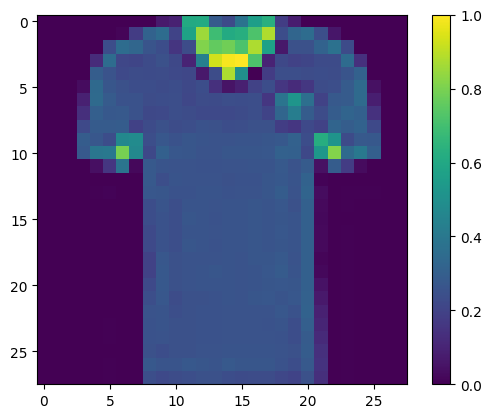

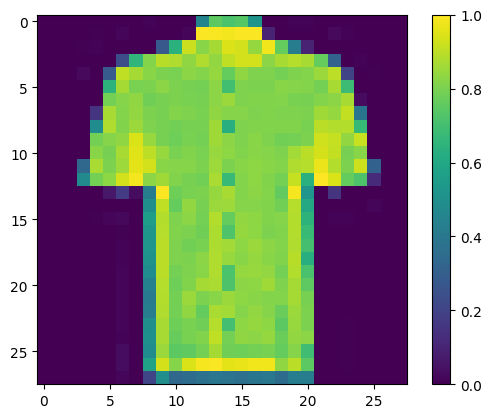

0.0


In [13]:
# array index
this_pair = 7

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

In [14]:
def feature_extractor():
    """ Given an Image (28X28) converts the image into a feature vector of dimension 128"""

    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

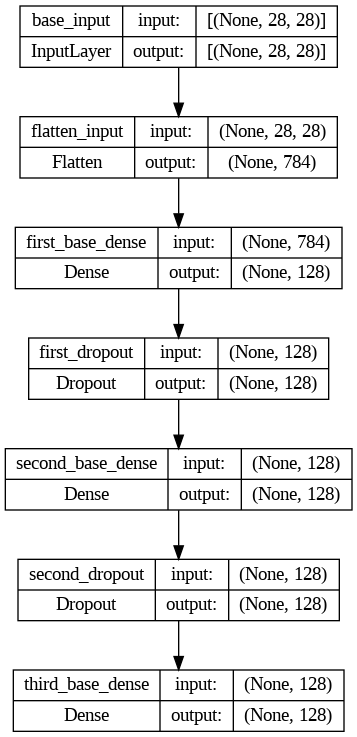

In [30]:
feature = feature_extractor()
plot_model(feature, show_shapes = True)

In [15]:
input_a = Input(shape = (28,28), name = "input_A")
input_b = Input(shape = (28,28), name = "input_B")

feature_a = feature(input_a)
feature_b = feature(input_b)

eucledian_layer = Lambda(euclidean_distance, name= "output_layer", output_shape=eucl_dist_output_shape)([feature_a, feature_b])

siamese_model = Model(inputs = [input_a,input_b], outputs = eucledian_layer)

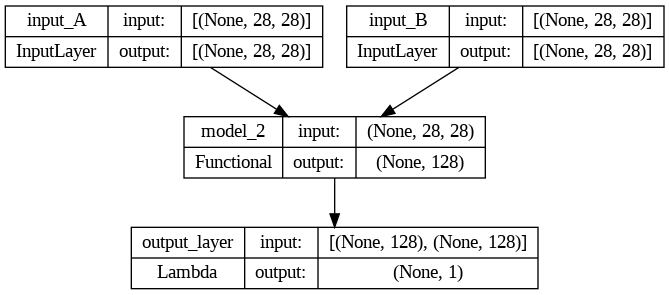

In [16]:
plot_model(siamese_model, show_shapes = True)

In [17]:
# custom loss function
def contrastive_loss_with_margin(margin = 0.1):
  def contrastive_loss(y_true, y_pred):
      squared_pred = K.square(y_pred)
      margin_square = K.square(K.maximum(margin - y_pred,0))
      return (y_true * squared_pred + (1 - y_true) * margin_square)
  return contrastive_loss   

In [18]:
siamese_model.compile(loss = contrastive_loss_with_margin(margin = 1),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
             )

In [19]:
history = siamese_model.fit(
                            [tr_pairs[:,0],tr_pairs[:,1]], tr_y,
                            validation_data = ([ts_pairs[:,0], ts_pairs[:,1]],ts_y), epochs = 20,
                            batch_size = 128
                           )

Epoch 1/20
938/938 [==============================] - 6s 5ms/step - loss: 0.1707 - val_loss: 0.1206
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1241 - val_loss: 0.1057
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1205 - val_loss: 0.1255
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1153 - val_loss: 0.1074
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1132 - val_loss: 0.1221
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1125 - val_loss: 0.1488
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1120 - val_loss: 0.0988
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1100 - val_loss: 0.1004
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1102 - val_loss: 0.1023
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.1130 - val_loss: 0.1065

In [20]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [21]:
loss = siamese_model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = siamese_model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = siamese_model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.09856415539979935, Train Accuracy = 0.8867227871311886 Test Accuracy = 0.8747247247247247


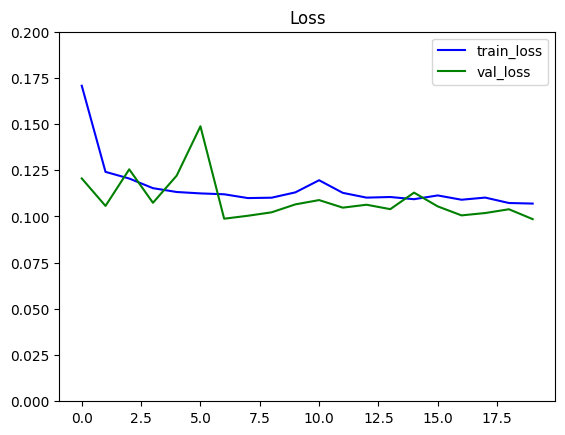

In [28]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label='train_'+ metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()
    

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [23]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


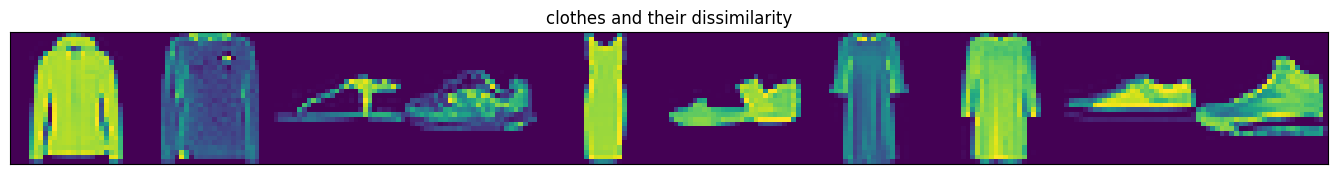

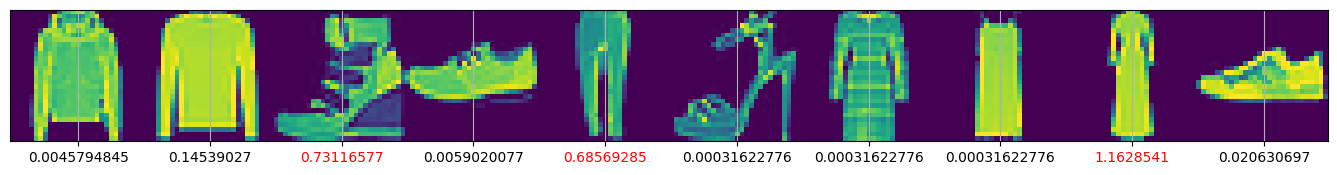

In [29]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)